$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [2]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, you can use a custom dataset, by editing the `PART3_CUSTOM_DATA_URL` variable in `hw4/answers.py`.

In [3]:
import cs236781.plot as plot
import cs236781.download
from hw4.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236781.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File /Users/romy/.pytorch-datasets/lfw-bush.zip exists, skipping download.
Extracting /Users/romy/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /Users/romy/.pytorch-datasets/lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [4]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


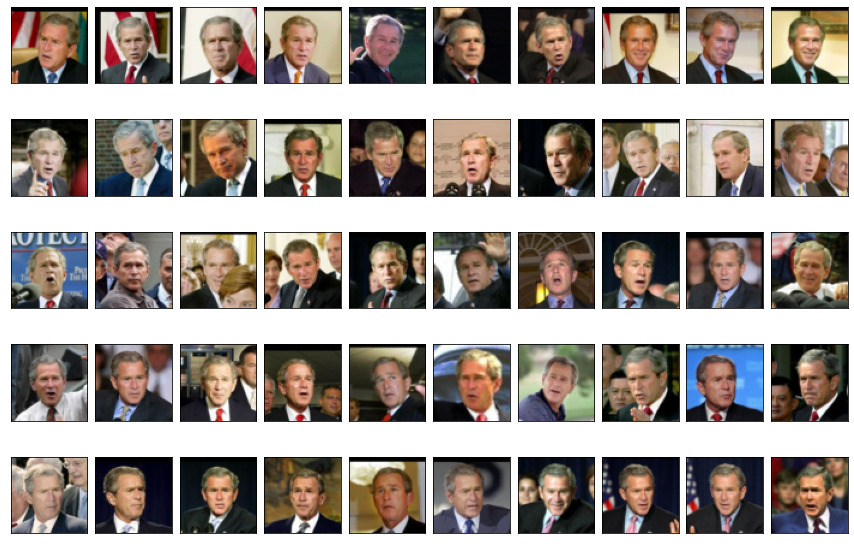

In [5]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(15,10), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [6]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the *loss* with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw4/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [7]:
import hw4.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (cnn): Sequential(
    (0): Conv2d(3, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(4, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(16, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=25, out_features=1, bias=True)
  )
)
torch.Size([1, 1])


**TODO**: Implement the `Generator` class in the `hw4/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [8]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (net): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
  (projection): Sequential(
    (0): Linear(in_features=128, out_features=16384, bias=True)
  )
)
torch.Size([1, 3, 64, 64])


### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw4/gan.py` module.

In [9]:
from hw4.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term. This corresponds to "fooling" the discriminator; Notice that the gradient of the loss w.r.t $\bb{\gamma}$ using this expression also depends on $\bb{\delta}$.

**TODO**: Implement the `generator_loss_fn()` function in the `hw4/gan.py` module.

In [10]:
from hw4.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw4/gan.py` module.

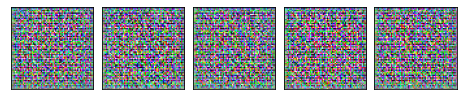

In [11]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw4/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparams()` function within the `hw4/answers.py` module.

In [13]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw4.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 4, 'z_dim': 512, 'data_label': 0, 'label_noise': 0.4, 'discriminator_optimizer': {'type': 'SGD', 'lr': 0.01}, 'generator_optimizer': {'type': 'SGD', 'lr': 0.01}}


**TODO**:
1. Implement the `save_checkpoint` function in the `hw4.gan` module. You can decide on your own criterion regarding whether to save a checkpoint at the end of each epoch.
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training. Note that your final submission zip will not include the `checkpoints/` folder. This is OK.

--- EPOCH 1/100 ---
100%|█████████████████████████████████████████| 133/133 [00:28<00:00,  4.67it/s]
Discriminator loss: 1.3612773373610991
Generator loss:     0.7768391115324838


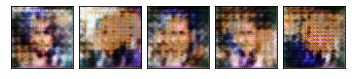

--- EPOCH 2/100 ---
100%|█████████████████████████████████████████| 133/133 [00:29<00:00,  4.57it/s]
Discriminator loss: 1.353277926158188
Generator loss:     0.7538853556589973


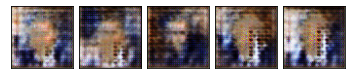

--- EPOCH 3/100 ---
100%|█████████████████████████████████████████| 133/133 [00:29<00:00,  4.53it/s]
Discriminator loss: 1.3340200499484414
Generator loss:     0.7980090760646906


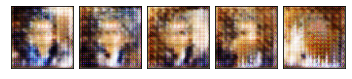

--- EPOCH 4/100 ---
100%|█████████████████████████████████████████| 133/133 [00:35<00:00,  3.78it/s]
Discriminator loss: 1.3310418805681674
Generator loss:     0.8058272622581711


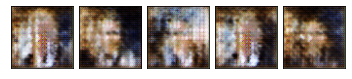

--- EPOCH 5/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.40it/s]
Discriminator loss: 1.3612716928460544
Generator loss:     0.7818780236674431


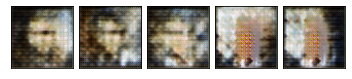

--- EPOCH 6/100 ---
100%|█████████████████████████████████████████| 133/133 [00:28<00:00,  4.62it/s]
Discriminator loss: 1.3134378329255527
Generator loss:     0.7463640691642475


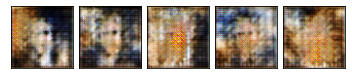

--- EPOCH 7/100 ---
100%|█████████████████████████████████████████| 133/133 [00:28<00:00,  4.69it/s]
Discriminator loss: 1.3780381191045719
Generator loss:     0.7370426462108928


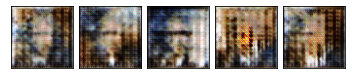

--- EPOCH 8/100 ---
100%|█████████████████████████████████████████| 133/133 [00:34<00:00,  3.85it/s]
Discriminator loss: 1.3114121394946163
Generator loss:     0.8153696891508604


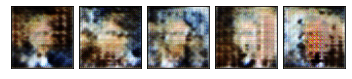

--- EPOCH 9/100 ---
100%|█████████████████████████████████████████| 133/133 [00:33<00:00,  3.92it/s]
Discriminator loss: 1.3627268837806874
Generator loss:     0.776933315105008


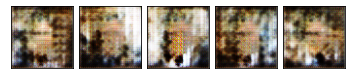

--- EPOCH 10/100 ---
100%|█████████████████████████████████████████| 133/133 [00:38<00:00,  3.46it/s]
Discriminator loss: 1.3678826972057945
Generator loss:     0.7519586512020656


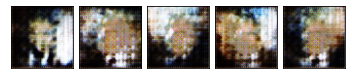

--- EPOCH 11/100 ---
100%|█████████████████████████████████████████| 133/133 [00:35<00:00,  3.80it/s]
Discriminator loss: 1.3360447986681658
Generator loss:     0.7902616858482361


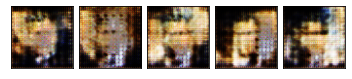

--- EPOCH 12/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.21it/s]
Discriminator loss: 1.3116696490380997
Generator loss:     0.7913338891545633


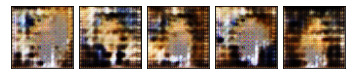

--- EPOCH 13/100 ---
100%|█████████████████████████████████████████| 133/133 [00:32<00:00,  4.06it/s]
Discriminator loss: 1.2946408184847438
Generator loss:     0.8173314055105797


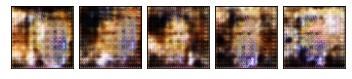

--- EPOCH 14/100 ---
100%|█████████████████████████████████████████| 133/133 [00:28<00:00,  4.64it/s]
Discriminator loss: 1.330717668945628
Generator loss:     0.8217142690393261


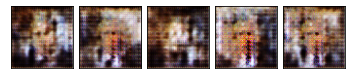

--- EPOCH 15/100 ---
100%|█████████████████████████████████████████| 133/133 [00:28<00:00,  4.70it/s]
Discriminator loss: 1.2794516014873534
Generator loss:     0.8819283063250377


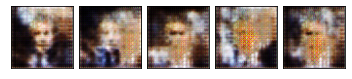

--- EPOCH 16/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.26it/s]
Discriminator loss: 1.3264111199773343
Generator loss:     0.8114233695922938


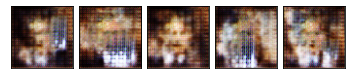

--- EPOCH 17/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.42it/s]
Discriminator loss: 1.3732305074992932
Generator loss:     0.7831786958346689


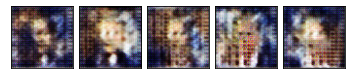

--- EPOCH 18/100 ---
100%|█████████████████████████████████████████| 133/133 [00:32<00:00,  4.07it/s]
Discriminator loss: 1.3156394420709825
Generator loss:     0.8114110406180074


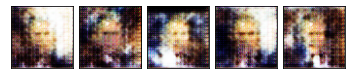

--- EPOCH 19/100 ---
100%|█████████████████████████████████████████| 133/133 [00:32<00:00,  4.07it/s]
Discriminator loss: 1.3141640612953587
Generator loss:     0.8553277307883241


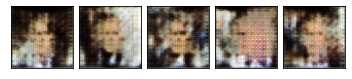

--- EPOCH 20/100 ---
100%|█████████████████████████████████████████| 133/133 [00:29<00:00,  4.44it/s]
Discriminator loss: 1.3257308136251635
Generator loss:     0.8442430688922566


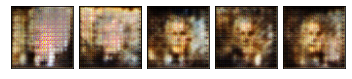

--- EPOCH 21/100 ---
100%|█████████████████████████████████████████| 133/133 [00:28<00:00,  4.71it/s]
Discriminator loss: 1.3306942053307267
Generator loss:     0.7536655525515851


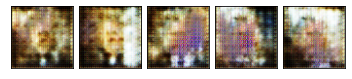

--- EPOCH 22/100 ---
100%|█████████████████████████████████████████| 133/133 [00:28<00:00,  4.63it/s]
Discriminator loss: 1.2691815999665654
Generator loss:     0.928295197791623


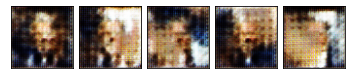

--- EPOCH 23/100 ---
100%|█████████████████████████████████████████| 133/133 [00:27<00:00,  4.76it/s]
Discriminator loss: 1.3326885328256994
Generator loss:     0.7756251746550539


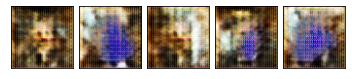

--- EPOCH 24/100 ---
100%|█████████████████████████████████████████| 133/133 [00:28<00:00,  4.65it/s]
Discriminator loss: 1.358824984919756
Generator loss:     0.7776076338793102


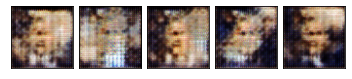

--- EPOCH 25/100 ---
100%|█████████████████████████████████████████| 133/133 [23:59<00:00, 10.82s/it]
Discriminator loss: 1.3053617580492693
Generator loss:     0.7909960948434988


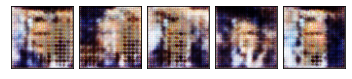

--- EPOCH 26/100 ---
100%|█████████████████████████████████████████| 133/133 [00:36<00:00,  3.66it/s]
Discriminator loss: 1.348939643766647
Generator loss:     0.7909385526090636


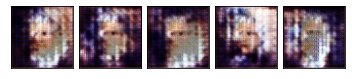

--- EPOCH 27/100 ---
100%|█████████████████████████████████████████| 133/133 [00:39<00:00,  3.39it/s]
Discriminator loss: 1.3605027579723443
Generator loss:     0.7755582498428517


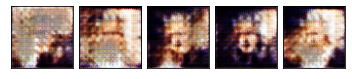

--- EPOCH 28/100 ---
100%|█████████████████████████████████████████| 133/133 [00:37<00:00,  3.56it/s]
Discriminator loss: 1.3628243584381907
Generator loss:     0.7874012177151845


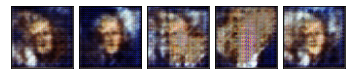

--- EPOCH 29/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.35it/s]
Discriminator loss: 1.3484721968048496
Generator loss:     0.7750240040004701


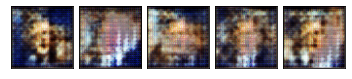

--- EPOCH 30/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.18it/s]
Discriminator loss: 1.3944145772690164
Generator loss:     0.7293257641613036


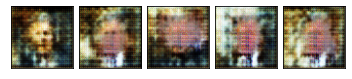

--- EPOCH 31/100 ---
100%|█████████████████████████████████████████| 133/133 [00:32<00:00,  4.10it/s]
Discriminator loss: 1.3444358065612334
Generator loss:     0.7094572049782688


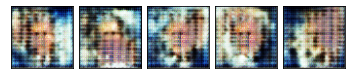

--- EPOCH 32/100 ---
100%|█████████████████████████████████████████| 133/133 [00:33<00:00,  4.00it/s]
Discriminator loss: 1.3868964551983023
Generator loss:     0.7158935560767812


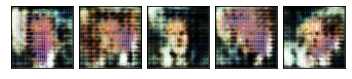

--- EPOCH 33/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.20it/s]
Discriminator loss: 1.371898485305614
Generator loss:     0.7572996813551824


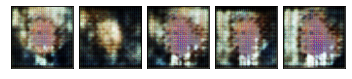

--- EPOCH 34/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.30it/s]
Discriminator loss: 1.3468890181161408
Generator loss:     0.7621907963788599


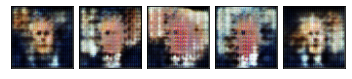

--- EPOCH 35/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.19it/s]
Discriminator loss: 1.3391794244149573
Generator loss:     0.7658723104268985


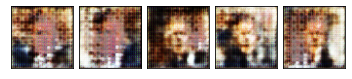

--- EPOCH 36/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.42it/s]
Discriminator loss: 1.3757759722551905
Generator loss:     0.7750920158131678


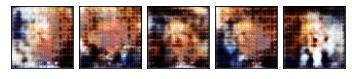

--- EPOCH 37/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.21it/s]
Discriminator loss: 1.353216873075729
Generator loss:     0.7472609581803917


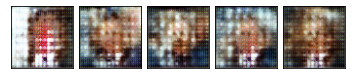

--- EPOCH 38/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.35it/s]
Discriminator loss: 1.386530635948468
Generator loss:     0.6613477049465466


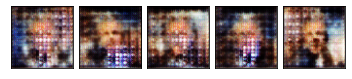

--- EPOCH 39/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.24it/s]
Discriminator loss: 1.379711373408038
Generator loss:     0.6873996737308072


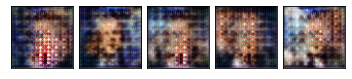

--- EPOCH 40/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.31it/s]
Discriminator loss: 1.3612149953842163
Generator loss:     0.7055589677695941


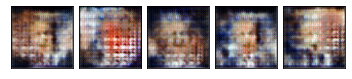

--- EPOCH 41/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.19it/s]
Discriminator loss: 1.3983838208635946
Generator loss:     0.6888383317710762


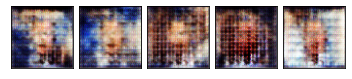

--- EPOCH 42/100 ---
100%|█████████████████████████████████████████| 133/133 [00:29<00:00,  4.53it/s]
Discriminator loss: 1.4074606949225403
Generator loss:     0.6762563035004121


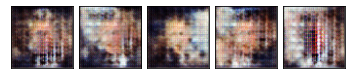

--- EPOCH 43/100 ---
100%|█████████████████████████████████████████| 133/133 [00:28<00:00,  4.67it/s]
Discriminator loss: 1.3895688307912726
Generator loss:     0.7187479797162508


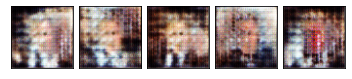

--- EPOCH 44/100 ---
100%|█████████████████████████████████████████| 133/133 [00:27<00:00,  4.92it/s]
Discriminator loss: 1.387302753620578
Generator loss:     0.697377728340321


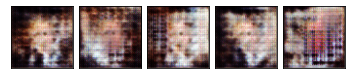

--- EPOCH 45/100 ---
100%|█████████████████████████████████████████| 133/133 [00:28<00:00,  4.71it/s]
Discriminator loss: 1.3809221131461007
Generator loss:     0.7106191462143919


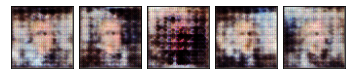

--- EPOCH 46/100 ---
100%|█████████████████████████████████████████| 133/133 [00:27<00:00,  4.90it/s]
Discriminator loss: 1.399391840275069
Generator loss:     0.6971177705248496


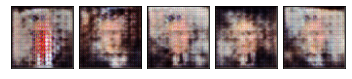

--- EPOCH 47/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.20it/s]
Discriminator loss: 1.3900526726156248
Generator loss:     0.7189247890522605


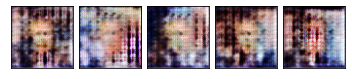

--- EPOCH 48/100 ---
100%|█████████████████████████████████████████| 133/133 [00:27<00:00,  4.84it/s]
Discriminator loss: 1.3859154084571321
Generator loss:     0.7078896944684193


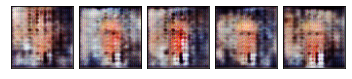

--- EPOCH 49/100 ---
100%|█████████████████████████████████████████| 133/133 [00:29<00:00,  4.50it/s]
Discriminator loss: 1.3643943394037117
Generator loss:     0.7274110178302106


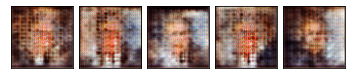

--- EPOCH 50/100 ---
100%|█████████████████████████████████████████| 133/133 [00:27<00:00,  4.82it/s]
Discriminator loss: 1.3860085512462414
Generator loss:     0.6928415022846451


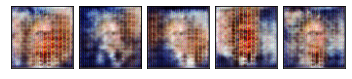

--- EPOCH 51/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.42it/s]
Discriminator loss: 1.377233802824092
Generator loss:     0.6874544288879051


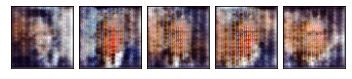

--- EPOCH 52/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.29it/s]
Discriminator loss: 1.3724496741043894
Generator loss:     0.7047534024805054


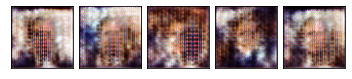

--- EPOCH 53/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.41it/s]
Discriminator loss: 1.3929707932292967
Generator loss:     0.7077379930288272


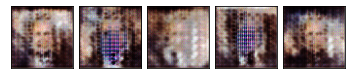

--- EPOCH 54/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.39it/s]
Discriminator loss: 1.3775214942774379
Generator loss:     0.7026135545027884


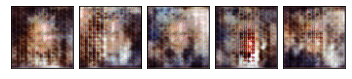

--- EPOCH 55/100 ---
100%|█████████████████████████████████████████| 133/133 [00:32<00:00,  4.10it/s]
Discriminator loss: 1.3894198971583431
Generator loss:     0.7005884270918997


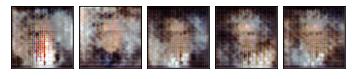

--- EPOCH 56/100 ---
100%|█████████████████████████████████████████| 133/133 [00:29<00:00,  4.44it/s]
Discriminator loss: 1.3808675179804177
Generator loss:     0.7141908115910408


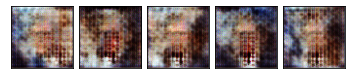

--- EPOCH 57/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.38it/s]
Discriminator loss: 1.3837377415563827
Generator loss:     0.7051679801223869


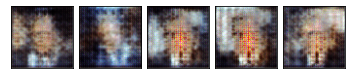

--- EPOCH 58/100 ---
100%|█████████████████████████████████████████| 133/133 [00:28<00:00,  4.64it/s]
Discriminator loss: 1.3683975701941584
Generator loss:     0.7369146907239928


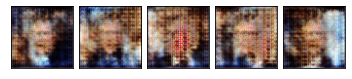

--- EPOCH 59/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.40it/s]
Discriminator loss: 1.3829459660035326
Generator loss:     0.6538807772155991


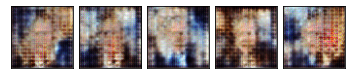

--- EPOCH 60/100 ---
100%|█████████████████████████████████████████| 133/133 [00:33<00:00,  3.95it/s]
Discriminator loss: 1.3677203225013905
Generator loss:     0.7293664266292313


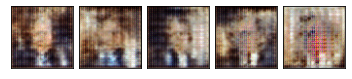

--- EPOCH 61/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.18it/s]
Discriminator loss: 1.3800513860874606
Generator loss:     0.7348918784829906


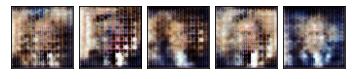

--- EPOCH 62/100 ---
100%|█████████████████████████████████████████| 133/133 [00:28<00:00,  4.73it/s]
Discriminator loss: 1.3744387053009262
Generator loss:     0.7359270601344288


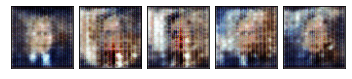

--- EPOCH 63/100 ---
100%|█████████████████████████████████████████| 133/133 [00:33<00:00,  4.01it/s]
Discriminator loss: 1.373998192916239
Generator loss:     0.7276788197065654


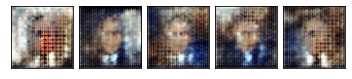

--- EPOCH 64/100 ---
100%|█████████████████████████████████████████| 133/133 [00:32<00:00,  4.14it/s]
Discriminator loss: 1.3920388490633857
Generator loss:     0.7200995710559357


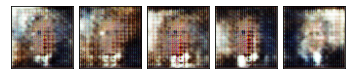

--- EPOCH 65/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.36it/s]
Discriminator loss: 1.369957351146784
Generator loss:     0.7154990430165055


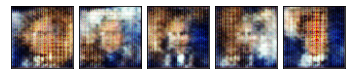

--- EPOCH 66/100 ---
100%|█████████████████████████████████████████| 133/133 [00:32<00:00,  4.09it/s]
Discriminator loss: 1.3607412388450222
Generator loss:     0.7023641113051795


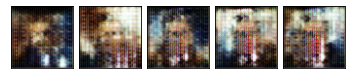

--- EPOCH 67/100 ---
100%|█████████████████████████████████████████| 133/133 [00:33<00:00,  4.02it/s]
Discriminator loss: 1.3709515377991182
Generator loss:     0.7412473272560234


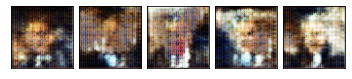

--- EPOCH 68/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.28it/s]
Discriminator loss: 1.3542222170005167
Generator loss:     0.7531414652677407


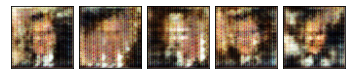

--- EPOCH 69/100 ---
100%|█████████████████████████████████████████| 133/133 [00:33<00:00,  3.98it/s]
Discriminator loss: 1.3692521493237717
Generator loss:     0.7447243252194914


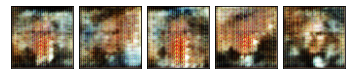

--- EPOCH 70/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.29it/s]
Discriminator loss: 1.3937095358855742
Generator loss:     0.7002077281923222


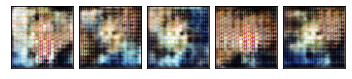

--- EPOCH 71/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.16it/s]
Discriminator loss: 1.392579540274197
Generator loss:     0.6932471712729088


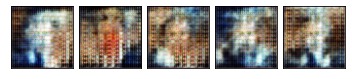

--- EPOCH 72/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.38it/s]
Discriminator loss: 1.3606340670047845
Generator loss:     0.6910830140113831


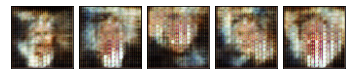

--- EPOCH 73/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.32it/s]
Discriminator loss: 1.380547304798786
Generator loss:     0.7060410550662449


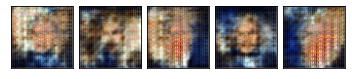

--- EPOCH 74/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.41it/s]
Discriminator loss: 1.3912733766369354
Generator loss:     0.6862335025816035


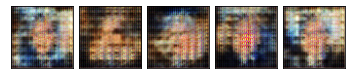

--- EPOCH 75/100 ---
100%|█████████████████████████████████████████| 133/133 [00:32<00:00,  4.09it/s]
Discriminator loss: 1.3533304427799426
Generator loss:     0.7621926060296539


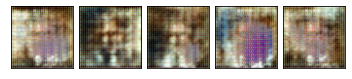

--- EPOCH 76/100 ---
100%|█████████████████████████████████████████| 133/133 [00:29<00:00,  4.46it/s]
Discriminator loss: 1.3760721602834256
Generator loss:     0.71099306004388


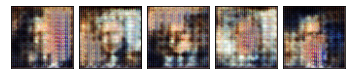

--- EPOCH 77/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.25it/s]
Discriminator loss: 1.375013388189158
Generator loss:     0.7724691799708775


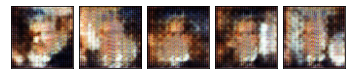

--- EPOCH 78/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.25it/s]
Discriminator loss: 1.3783018929617745
Generator loss:     0.7241247108108119


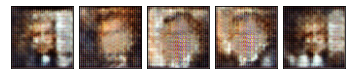

--- EPOCH 79/100 ---
100%|█████████████████████████████████████████| 133/133 [00:33<00:00,  3.93it/s]
Discriminator loss: 1.3538859948179776
Generator loss:     0.7574535751701298


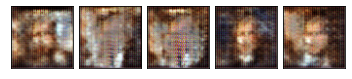

--- EPOCH 80/100 ---
100%|█████████████████████████████████████████| 133/133 [00:33<00:00,  3.97it/s]
Discriminator loss: 1.3742202932673289
Generator loss:     0.7243723779692686


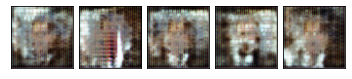

--- EPOCH 81/100 ---
100%|█████████████████████████████████████████| 133/133 [00:42<00:00,  3.10it/s]
Discriminator loss: 1.363932890999586
Generator loss:     0.7276730062370014


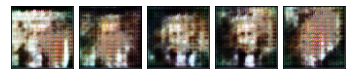

--- EPOCH 82/100 ---
100%|█████████████████████████████████████████| 133/133 [00:37<00:00,  3.53it/s]
Discriminator loss: 1.3647771491143936
Generator loss:     0.7565775791505226


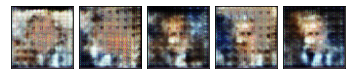

--- EPOCH 83/100 ---
100%|█████████████████████████████████████████| 133/133 [00:32<00:00,  4.09it/s]
Discriminator loss: 1.38117810299522
Generator loss:     0.7473030493671733


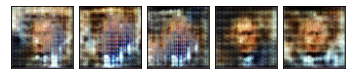

--- EPOCH 84/100 ---
100%|█████████████████████████████████████████| 133/133 [00:32<00:00,  4.14it/s]
Discriminator loss: 1.3946288716524167
Generator loss:     0.6966705824199476


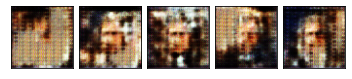

--- EPOCH 85/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.23it/s]
Discriminator loss: 1.3750159507407282
Generator loss:     0.7198978205372516


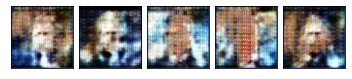

--- EPOCH 86/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.27it/s]
Discriminator loss: 1.3447362444454567
Generator loss:     0.74971271054189


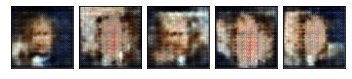

--- EPOCH 87/100 ---
100%|█████████████████████████████████████████| 133/133 [00:29<00:00,  4.48it/s]
Discriminator loss: 1.3901844266662025
Generator loss:     0.7170487498878536


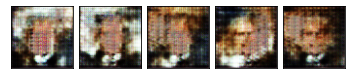

--- EPOCH 88/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.30it/s]
Discriminator loss: 1.356699283857991
Generator loss:     0.7160336357310302


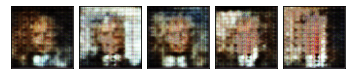

--- EPOCH 89/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.26it/s]
Discriminator loss: 1.3760145544109488
Generator loss:     0.7182338896550631


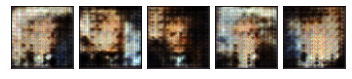

--- EPOCH 90/100 ---
100%|█████████████████████████████████████████| 133/133 [00:33<00:00,  4.03it/s]
Discriminator loss: 1.3508277844665642
Generator loss:     0.7397988003895695


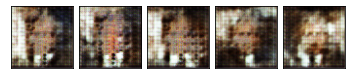

--- EPOCH 91/100 ---
100%|█████████████████████████████████████████| 133/133 [00:29<00:00,  4.49it/s]
Discriminator loss: 1.3720417040631288
Generator loss:     0.7488065503145519


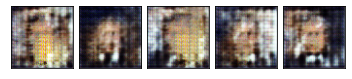

--- EPOCH 92/100 ---
100%|█████████████████████████████████████████| 133/133 [00:29<00:00,  4.44it/s]
Discriminator loss: 1.342560267089901
Generator loss:     0.7304007343779829


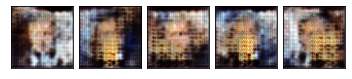

--- EPOCH 93/100 ---
100%|█████████████████████████████████████████| 133/133 [00:29<00:00,  4.55it/s]
Discriminator loss: 1.3711320430712592
Generator loss:     0.7673848535781517


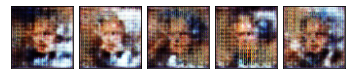

--- EPOCH 94/100 ---
100%|█████████████████████████████████████████| 133/133 [00:28<00:00,  4.72it/s]
Discriminator loss: 1.3838464720804888
Generator loss:     0.6711053323924989


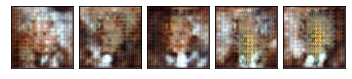

--- EPOCH 95/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.27it/s]
Discriminator loss: 1.4033516260018026
Generator loss:     0.6842943461317765


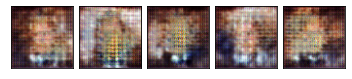

--- EPOCH 96/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.42it/s]
Discriminator loss: 1.380405118590907
Generator loss:     0.72748539411932


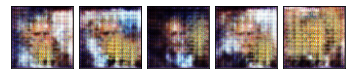

--- EPOCH 97/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.29it/s]
Discriminator loss: 1.377022463576238
Generator loss:     0.7070425565081432


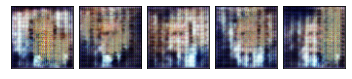

--- EPOCH 98/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.30it/s]
Discriminator loss: 1.3909148614209397
Generator loss:     0.7345977582429585


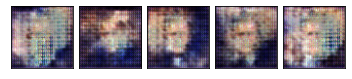

--- EPOCH 99/100 ---
100%|█████████████████████████████████████████| 133/133 [00:29<00:00,  4.48it/s]
Discriminator loss: 1.3459629752582176
Generator loss:     0.7756604776346594


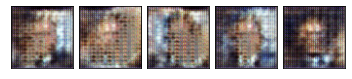

--- EPOCH 100/100 ---
100%|█████████████████████████████████████████| 133/133 [00:29<00:00,  4.48it/s]
Discriminator loss: 1.3605147465727383
Generator loss:     0.7258370196012626


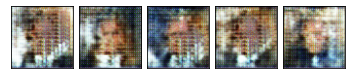

In [17]:
import IPython.display
import tqdm
from hw4.gan import train_batch, save_checkpoint

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device,)
    checkpoint_file = checkpoint_file_final

try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_train):
                x_data = x_data.to(device)
                dsc_loss, gen_loss = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()

        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            

        samples = gen.sample(5, with_grad=False)
        fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

*** Images Generated from best model:


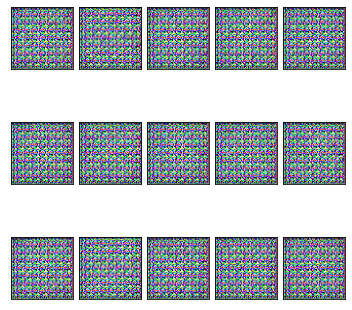

In [13]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw4/answers.py`.

In [14]:
from cs236781.answers import display_answer
import hw4.answers as answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [15]:
display_answer(answers.part3_q1)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$



### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [16]:
display_answer(answers.part3_q2)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$



### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [17]:
display_answer(answers.part3_q3)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$

